In [261]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl

In [262]:
# Constants
DIMENSIONS: int = 10                                # Fixed at n=10 for both functions
BITS_PER_DIMENSION: int = 16
DOMAIN_1: tuple[float, float] = (-3, 3)
DOMAIN_2: tuple[float, float] = (-32.768, 32.768)
MAX_EVALUATIONS: int = 10000
REPETITIONS: int = 100
INITIAL_TEMPERATURE: float = 1000.0                 # Starting temperature for SA
COOLING_RATE: float = 0.98                          # Temperature decrease factor per iteration
BUFFER_SIZE = 10                                    # Buffer to check for local minimum

# Generate Solutions

In [263]:
def generate_initial_solution_binary() -> np.ndarray:
    """Generates an initial binary solution for Simulated Annealing.
    
    Returns:
    - np.ndarray: Array of binary strings (dtype=object), each of length BITS_PER_DIMENSION.
    """
    return np.array(['1' * BITS_PER_DIMENSION for _ in range(DIMENSIONS)], dtype=object)

In [264]:
def generate_initial_solution_real(domain: tuple[float, float]) -> np.ndarray:
    """Generates an initial real-valued solution for Simulated Annealing within the domain.

    Parameters:
    - domain (tuple[float, float]): Lower and upper bounds of the solution space.

    Returns:
    - np.ndarray: Array of real values (dtype=float) within the specified domain.
    """
    min_val, max_val = domain
    return np.random.uniform(min_val, max_val, DIMENSIONS).astype(float)

# Generate Neighbors

In [265]:
def generate_neighbor_binary(binary_solution: np.ndarray) -> np.ndarray:
    """Generates a binary neighbor solution by flipping a random bit in the solution.

    Parameters:
    - binary_solution (np.ndarray): Array of binary strings (dtype=object).

    Returns:
    - np.ndarray: New solution with a single bit flipped.
    """
    new_solution = binary_solution.copy()
    dim = np.random.randint(len(binary_solution))
    bit = np.random.randint(len(binary_solution[dim]))
    new_solution[dim] = (
        new_solution[dim][:bit] +
        ('1' if new_solution[dim][bit] == '0' else '0') + 
        new_solution[dim][bit+1:]
    )
    return new_solution

In [266]:
def generate_neighbor_real(real_solution: np.ndarray) -> np.ndarray:
    """Generates a real-valued neighbor solution by adding a small Gaussian noise.

    Parameters:
    - real_solution (np.ndarray): Current real-valued solution (dtype=float).

    Returns:
    - np.ndarray: New solution with Gaussian noise added (dtype=float).
    """
    return real_solution + np.random.normal(0, 1, real_solution.shape)

# Binary Utility Functions

In [267]:
def binary_to_real(binary_str: str, min_val: float, max_val: float) -> float:
    """Converts a binary string to a real number within a specified range.

    Parameters:
    - binary_str (str): Binary string representation.
    - min_val (float): Minimum value of the real range.
    - max_val (float): Maximum value of the real range.

    Returns:
    - float: Converted real value.
    """
    decimal_value = int(binary_str, 2)
    max_decimal = 2**len(binary_str) - 1
    return min_val + (max_val - min_val) * decimal_value / max_decimal

In [268]:
def decode_solution_binary(binary_solution: np.ndarray, domain: tuple[float, float]) -> np.ndarray:
    """Decodes a binary solution into real numbers within the specified domain.

    Parameters:
    - binary_solution (np.ndarray): Array of binary strings (dtype=object).
    - domain (tuple[float, float]): Lower and upper bounds of the solution space.

    Returns:
    - np.ndarray: Array of real values (dtype=float).
    """
    min_val, max_val = domain
    return np.array([binary_to_real(bits, min_val, max_val) for bits in binary_solution], dtype=float)

# Evaluation Functions

### Function One
$$
f_1(x) = - \frac{5}{1 + \sum_{i=1}^{n} x_{i}} + \sin\left(\cot\left(e^{\left(- \frac{5}{1 + \sum_{i=1}^{n} x_{i}}\right)}\right)\right)
$$

where:
- $x_i \in [-3, 3], $
- $\forall i = 1, \dots, n$

In [269]:
def evaluate_f1(solution: np.ndarray, domain: tuple[float, float]) -> float:
    """Evaluates the first function (F1) on a given solution.
    
    Parameters:
    - solution (np.ndarray): Solution array in either binary or real format.
    - domain (tuple[float, float]): Domain bounds.

    Returns:
    - float: Calculated function value.
    """
    if isinstance(solution[0], str):  # Detect binary solution
        solution = decode_solution_binary(solution, domain)
    
    sum_solution = np.sum(solution)
    try:
        # Constrain exp_val to avoid overflow and extreme values
        exp_val = np.clip(-5 / (1 + sum_solution), -700, 700)
        y = exp_val + np.sin(1 / np.tan(np.exp(exp_val)))
    except (OverflowError, ZeroDivisionError, ValueError):
        y = float('inf')
    return y

### Function Two
$$
f_2(x) = -a \cdot \exp\left(-b \sqrt{\frac{1}{d} \sum_{i=1}^{d} x_{i}^2}\right) - \exp\left(\frac{1}{d} \sum_{i=1}^{d} \cos(c \cdot x_{i})\right) + a + \exp(1)
$$

with recommended values 
- a = 20,
- b = 0.2,
- $c = 2 \pi,$
- $x_{i} \in [-32.768, 32.768],$
- $\forall  i = 1, \dots, n$

In [270]:
def evaluate_f2(solution: np.ndarray, domain: tuple[float, float], a: float = 20, b: float = 0.2, c: float = 2 * np.pi) -> float:
    """Evaluates the second function (F2) on a given solution.

    Parameters:
    - solution (np.ndarray): Solution array in either binary or real format.
    - domain (tuple[float, float]): Domain bounds.

    Returns:
    - float: Calculated function value.
    """
    if isinstance(solution[0], str):  # Detect binary solution
        solution = decode_solution_binary(solution, domain)
    
    d = len(solution)
    sum_1 = np.sum(solution ** 2)
    sum_2 = np.sum(np.cos(c * solution))
    return -a * np.exp(-b * np.sqrt(sum_1 / d)) - np.exp(sum_2 / d) + a + np.exp(1)

# Simulated Annealing Function

In [271]:
def simulated_annealing(domain: tuple[float, float], evaluate_func, neighbor_func, init_func) -> list[float]:
    """
    Performs Simulated Annealing to optimize a given function.

    Parameters:
    - domain (tuple[float, float]): Range of values for each dimension.
    - evaluate_func (callable): Function to evaluate the solution.
    - neighbor_func (callable): Function to generate neighboring solutions.
    - init_func (callable): Function to initialize the solution.

    Returns:
    - list[float]: List of best values found over the course of the search.
    """
    # Check if init_func needs a domain argument and call it appropriately
    if 'domain' in init_func.__code__.co_varnames:
        solution = init_func(domain)
    else:
        solution = init_func()
    
    # Evaluate the initial solution
    best_value: float = evaluate_func(solution, domain)
    evaluations: list[float] = [best_value]
    eval_count: int = 1
    temperature: float = INITIAL_TEMPERATURE

    # Main loop for simulated annealing
    while eval_count < MAX_EVALUATIONS:
        neighbor: np.array = neighbor_func(solution)
        neighbor_value: float = evaluate_func(neighbor, domain)
        eval_count += 1

        # Metropolis criterion
        if neighbor_value < best_value or np.random.rand() < np.exp((best_value - neighbor_value) / temperature):
            solution = neighbor
            best_value = neighbor_value

        evaluations.append(best_value)
        temperature *= COOLING_RATE

    return evaluations

# Main part functions

In [272]:
def run_experiment(domain: tuple[float, float], evaluate_func, neighbor_func, init_func) -> pd.DataFrame:
    """
    Runs the Simulated Annealing optimization multiple times.

    Parameters:
    - domain (tuple[float, float]): The range of values for each dimension.
    - evaluate_func (callable): Function to evaluate the solution.
    - neighbor_func (callable): Function to generate neighboring solutions.
    - init_func (callable): Function to initialize the solution.

    Returns:
    - pd.DataFrame: DataFrame of all optimization runs.
    """
    all_runs = []
    for _ in range(REPETITIONS):
        # Pass domain if needed within `simulated_annealing`
        best_values = simulated_annealing(domain, evaluate_func, neighbor_func, init_func)
        all_runs.append(best_values)
    return pd.DataFrame(all_runs).T

In [273]:
def plot_results(results: pd.DataFrame, function_name: str, representation: str) -> None:
    """Plots the averaged optimization results.

    Parameters:
    - results (pd.DataFrame): Data of optimization results.
    - function_name (str): Name of the function.
    - representation (str): Representation name.
    """
    mean_values = results.mean(axis=1)
    plt.figure(figsize=(10, 6))
    plt.plot(mean_values, label=f'{function_name} ({representation})')
    plt.xlabel('Evaluation Count')
    plt.ylabel('Best Function Value Found')
    if 'F1' in function_name:
        plt.xscale('log')
        plt.yscale('log')
    else:
        plt.yscale('log')
    plt.title(f'Simulated Annealing Performance on {function_name} ({representation})')
    plt.legend()
    plt.savefig(f'Simulated-Annealing-{function_name}-{representation}.png')
    plt.show()

In [274]:
def save_to_excel(results: pd.DataFrame, sheet_name: str, filename: str = 'optimization_results_sa.xlsx') -> None:
    """Saves the results to an Excel file.

    Parameters:
    - results (pd.DataFrame): Data to save.
    - sheet_name (str): Name of the sheet.
    - filename (str): Name of the output file.
    """
    with pd.ExcelWriter(filename) as writer:
        results_f1_binary.to_excel(writer, sheet_name="F1_Binary")
        results_f1_real.to_excel(writer, sheet_name="F1_Real")
        results_f2_binary.to_excel(writer, sheet_name="F2_Binary")
        results_f2_real.to_excel(writer, sheet_name="F2_Real")

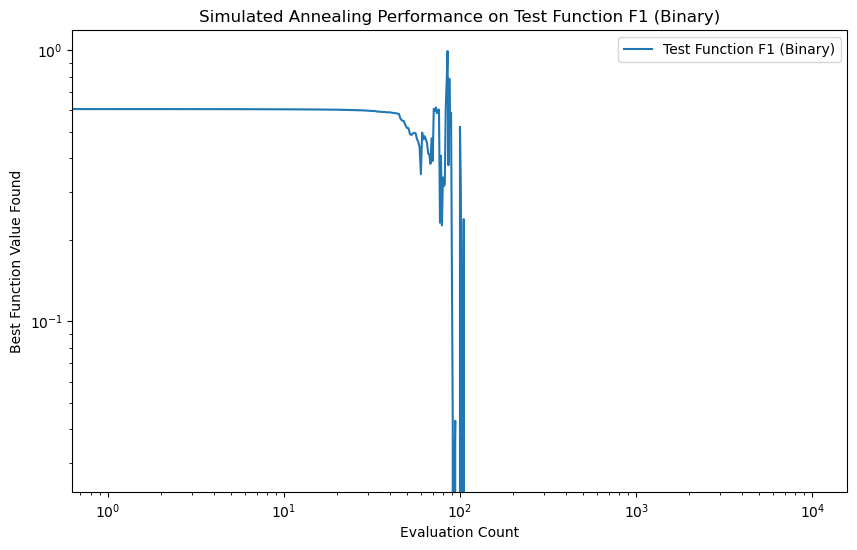

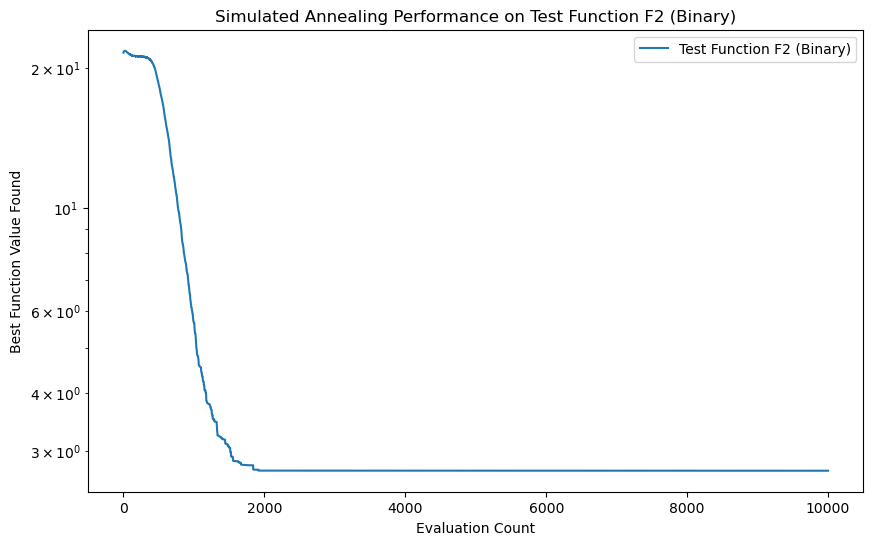

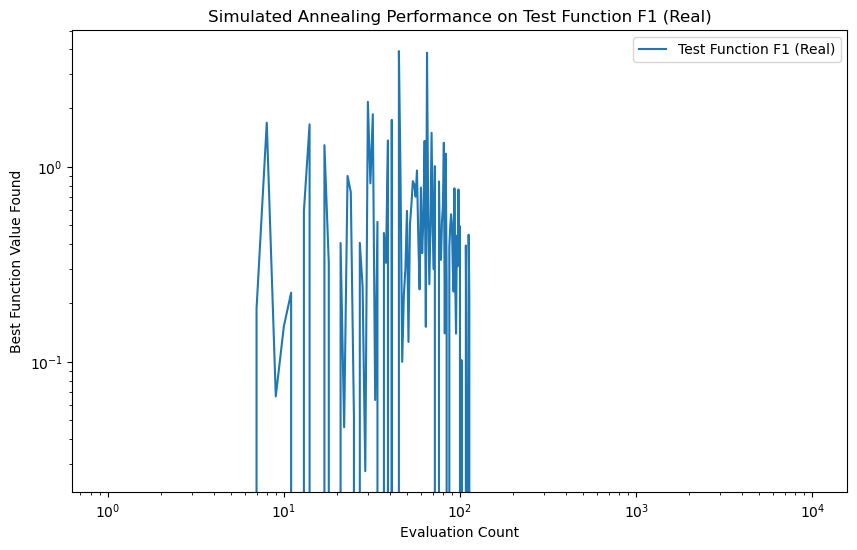

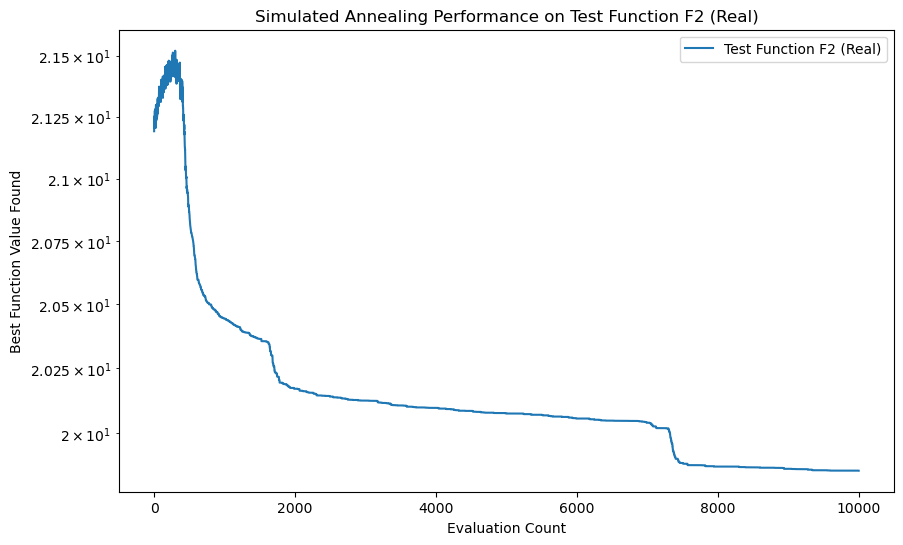

In [275]:
# Run Experiments for Binary and Real Representations
results_f1_binary = run_experiment(DOMAIN_1, evaluate_f1, generate_neighbor_binary, generate_initial_solution_binary)
results_f2_binary = run_experiment(DOMAIN_2, evaluate_f2, generate_neighbor_binary, generate_initial_solution_binary)
results_f1_real = run_experiment(DOMAIN_1, evaluate_f1, generate_neighbor_real, generate_initial_solution_real)
results_f2_real = run_experiment(DOMAIN_2, evaluate_f2, generate_neighbor_real, generate_initial_solution_real)

# Plot and Save Results
plot_results(results_f1_binary, 'Test Function F1', 'Binary')
plot_results(results_f2_binary, 'Test Function F2', 'Binary')
plot_results(results_f1_real, 'Test Function F1', 'Real')
plot_results(results_f2_real, 'Test Function F2', 'Real')

In [276]:
save_to_excel(results_f1_binary, 'F1_Binary')
save_to_excel(results_f2_binary, 'F2_Binary')
save_to_excel(results_f1_real, 'F1_Real')
save_to_excel(results_f2_real, 'F2_Real')